In [1]:
# Install the required libraries (from pip_requirements.txt)
%pip install -r pip_requirements.txt

!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Initial analysis

In [2]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload

In [3]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

### IV.3 Theme Study for Cultural Influence Analysis

### nouvelle méthode pour le score d'influence

In [4]:
from scriptculture import process_data_us_influence          # Import the function that processes the data for this study

df_us_influence = process_data_us_influence()
df_us_influence.head()

,Country,US_Term_Count,Number of movies,Influence_score,log_number_of_movies,World_region
0,France,531,2297,0.231171,7.739359,Europe
1,Soviet Union,30,255,0.117647,5.541264,Eastern Europe and Central Asia
2,Russia,18,217,0.082949,5.379897,Eastern Europe and Central Asia
3,United States of America,7657,20789,0.368320,9.942179,North America
4,India,262,4752,0.055135,8.466321,South Asia


In [15]:
from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
resume = "In Los Angeles, California Fletcher Reede  is a career-focused lawyer and divorced father. He loves spending time with his young son Max ([[Justin Cooper ; they often play a game where Fletcher makes his hand into the Claw and pretends to chase Max with it. But Fletcher has a habit of giving precedence to his job, breaking promises to Max and his ex-wife Audrey , and then lying about the reasons. Fletcher's compulsive lying has also built him a reputation as one of the best defense lawyers in the state of California as he is climbing the ladder in the firm for which he works. Ultimately, Fletcher misses his son's fifth birthday party because he is having sex with his boss Miranda , in the hopes of making partner. Max makes a birthday wish that his father would be unable to tell a lie for an entire day &mdash; a wish that immediately becomes true. Fletcher soon discovers, through a series of embarrassing incidents &mdash; such as when he tells Miranda that he has had better sex than he just did with her &mdash; that he is unable to lie, mislead, or even withhold a true answer. These incidents are inconvenient, as he is fighting a divorce case in court which, should he win, could be a huge boost to his career. His client is the self-centered, money grabbing Samantha Cole . His main witness is willing to commit perjury to win, but Fletcher discovers that he cannot even ask a question if he knows the answer will be a lie; during the case he even objects to himself when he tries to lie to get the desired information. Meanwhile, Audrey is planning to move to Boston with her new boyfriend Jerry , and decides that Max is going with them so that she can protect him from getting hurt by Fletcher. Fletcher tries desperately to delay the case, even beating himself up, but he cannot conceal that he is able to continue, so the judge  insists that he does. Finally he realizes that his client had lied about her age and therefore had signed her prenuptial agreement while a minor, rendering it invalid. This allows him to win his case truthfully, but the repercussions become a catalyst to his understanding of what he himself is about to lose. Samantha who only cared about her ex-husband's money, takes custody of her children purely so her ex-husband would be forced to continue paying her for child care and literally pulls the children out of the arms of their responsible and caring father. Fletcher then has a crisis of conscience and shouts at the judge to reverse the decision, and is taken to jail for contempt of court. Audrey refuses to pay his bail, which is eventually paid by his secretary Greta , who forgives him for his earlier rude truth-tellings after hearing he went all noble in front of their firm's senior partner. Now recognizing his son Max as his highest priority, Fletcher struggles to keep him. He hurries to the airport, but Audrey and Max's plane has already left the terminal. Desperate, he hijacks a mobile stairway and pursues the plane onto the runway. The plane finally stops, but Fletcher is injured. On his way to the hospital, he vows to his son to spend more time with him and never hurt him again. Even though the 24 hours of truth are up, Max knows he means it, and Audrey decides not to move to Boston with Jerry after all. One year later, Fletcher and Audrey are celebrating Max's birthday. The lights go off when Max blows out his birthday candles. When they go back on, Fletcher and Audrey are kissing. Fletcher asks Max if he wished for his mom and his dad to get back together and Max replies No, I wished for roller blades! The family seemingly returns to normal as Fletcher chases Audrey and Max around the house with the Claw."

# Here we define the label (countries in our case)
labels = ["United States"]

result = nlp(resume, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head()

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Label,Score
0,United States,0.299839


In [5]:
# Import dataloader function
from dataLoader import loadDataframe

In [6]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)
df_characters = loadDataframe('characters', path_to_directory)
df_clusters = loadDataframe('clusters', path_to_directory)
df_summaries = loadDataframe('summaries', path_to_directory)

c:\Users\Oscar\Project ADA\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


In [7]:
df_movies_merge = pd.merge(df_summaries, df_movies, how='inner')
#on enlève tous les pays qui correspondent à United States of America
df_movies_merge = df_movies_merge[~df_movies_merge['countries'].apply(lambda x: 'United States of America' in x)]
df_movies_merge = df_movies_merge[['wiki_id','summary','countries']]
df_movies_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21416 entries, 0 to 42203
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wiki_id    21416 non-null  int64 
 1   summary    21416 non-null  object
 2   countries  21416 non-null  object
dtypes: int64(1), object(2)
memory usage: 669.2+ KB


In [40]:
df_movies_merge_test = df_movies_merge.head(30).copy()

In [29]:
from transformers import pipeline
import pandas as pd

# Charger le pipeline de classification zéro-shot
nlp = pipeline("zero-shot-classification")

# Exemple de fonction pour calculer le score
def compute_score(row, label):
    """
    Calcule le score de correspondance entre le résumé et un label donné.
    
    Args:
    - row: Une ligne du DataFrame contenant au moins 'summary'.
    - label: Le label à comparer (ici un pays).
    
    Returns:
    - Score de correspondance entre le texte et le label.
    """
    result = nlp(row['summary'], candidate_labels=[label])
    return result['scores'][0]  # Le score du premier label (label unique)

# Exemple : Ajouter une colonne 'score' avec le score pour le label "United States"
label = "United States"
df_movies_merge_test.loc[:, 'score'] = df_movies_merge_test.apply(lambda row: compute_score(row, label), axis=1)

df_movies_merge_test.head(20)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,wiki_id,summary,countries,score
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[France, Soviet Union, Russia]",0.000472
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[India],0.002418
9,20532852,A line of people drool at the window of the s...,[],0.595722
11,18188932,Milan and Goran are two criminals who smuggle ...,[Czech Republic],0.006639
12,2940516,Bumbling pirate crewman kills his captain aft...,[United Kingdom],0.296449
15,24448645,"Despite Lucy's reservations, she agrees to her...",[],0.377025
18,4596602,"Ashes to Ashes is set in London, England. The ...",[United Kingdom],0.000232
20,15585766,Three friends are droving cattle in Australia ...,[Australia],0.001255
22,29062594,A group of teenagers at Catholic boarding scho...,[],0.000058
25,8388648,The film opens with Madhav and Sreenu playin...,[India],0.044223


La fonction suivante calcule le score pour chacun des films et l'enregistre dans le csv "scores.csv". Je peux choisir la taille des batchs à chaque fois puisque la taille de mon dataframe est quand même 21 000 et que je ne peux pas tout faire tourner en 1 fois.

In [ ]:
import pandas as pd
from transformers import pipeline

# Charger le pipeline de classification zéro-shot
nlp = pipeline("zero-shot-classification")

# Exemple de fonction pour calculer le score
def compute_score(row, label):
    """
    Calcule le score de correspondance entre le résumé et un label donné.
    
    Args:
    - row: Une ligne du DataFrame contenant au moins 'summary'.
    - label: Le label à comparer (ici un pays).
    
    Returns:
    - Score de correspondance entre le texte et le label.
    """
    result = nlp(row['summary'], candidate_labels=[label])
    return result['scores'][0]  # Le score du premier label (label unique)
# Fonction pour traiter le DataFrame en plusieurs fois
def process_in_chunks(df, label, chunk_size=100, output_file='scores.csv'):
    """
    Traite le DataFrame en plusieurs morceaux et sauvegarde les résultats.
    
    Args:
    - df: Le DataFrame à traiter.
    - label: Le label à comparer.
    - chunk_size: Le nombre de lignes à traiter à chaque fois.
    - output_file: Le nom du fichier de sortie.
    """
    # Si le fichier existe déjà, on le charge pour éviter de réécrire les résultats déjà calculés
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        start_index = len(existing_df)  # On reprend à la dernière ligne calculée
        print(f"Reprise à la ligne {start_index}")
    else:
        existing_df = pd.DataFrame()
        start_index = 0  # Si le fichier n'existe pas, on commence depuis 0
    
    # Diviser le DataFrame en morceaux (chunks)
    for i in range(start_index, len(df), chunk_size):
        chunk = df.iloc[i:i+chunk_size]
        # Calculer les scores pour ce morceau
        chunk.loc[:, 'score'] = chunk.apply(lambda row: compute_score(row, label), axis=1)
        
        # Utilisation de pd.concat() pour ajouter le chunk au DataFrame existant
        existing_df = pd.concat([existing_df, chunk], ignore_index=True)
        
        # Sauvegarder ce morceau dans le fichier de sortie
        existing_df.to_csv(output_file, index=False)
        print(f"Progress: Traitement des lignes {i} à {i+chunk_size-1}")

# Exemple d'utilisation
import os

# Traitement par morceaux (par exemple 1000 lignes à la fois)
process_in_chunks(df_movies_merge, label='United States', chunk_size=100, output_file='scores.csv')

In [4]:
df_test = pd.read_csv('scores.csv')
df_test.head(10)

,wiki_id,summary,countries,score
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","['France', 'Soviet Union', 'Russia']",0.000472
1,20663735,Poovalli Induchoodan is sentenced for six yea...,['India'],0.002418
2,20532852,A line of people drool at the window of the s...,[],0.595722
3,18188932,Milan and Goran are two criminals who smuggle ...,['Czech Republic'],0.006639
4,2940516,Bumbling pirate crewman kills his captain aft...,['United Kingdom'],0.296449
5,24448645,"Despite Lucy's reservations, she agrees to her...",[],0.377025
6,4596602,"Ashes to Ashes is set in London, England. The ...",['United Kingdom'],0.000232
7,15585766,Three friends are droving cattle in Australia ...,['Australia'],0.001255
8,29062594,A group of teenagers at Catholic boarding scho...,[],0.000058
9,8388648,The film opens with Madhav and Sreenu playin...,['India'],0.044223


For this analysis, we identified a list of typically american words. We then search for this words occurences in the different summaries. We then grouped the results by countries.

The processed dataset that we'll use for this analyse is completed with the features :
 - US_Term_Count : Number of us terms found in the movies from each country
 - Number of movies : number of movies in each country
 - Influence score : ratio of US_Term_Count/Number of movies
 - World_region : Geographical cluster that we identified 


In [26]:
import scriptculture
reload(scriptculture)

ModuleNotFoundError: No module named 'scriptculture'

In [ ]:
df_us_influence.describe()

,US_Term_Count,Number of movies,Influence_score,log_number_of_movies
count,147.000000,147.000000,147.000000,147.000000
mean,85.088435,321.510204,0.147156,3.290563
std,639.985937,1797.950894,0.230474,1.925694
min,0.000000,2.000000,0.000000,0.693147
25%,0.000000,6.000000,0.000000,1.791759
50%,2.000000,17.000000,0.090909,2.833213
75%,14.000000,101.000000,0.202210,4.615121
max,7657.000000,20789.000000,2.000000,9.942179


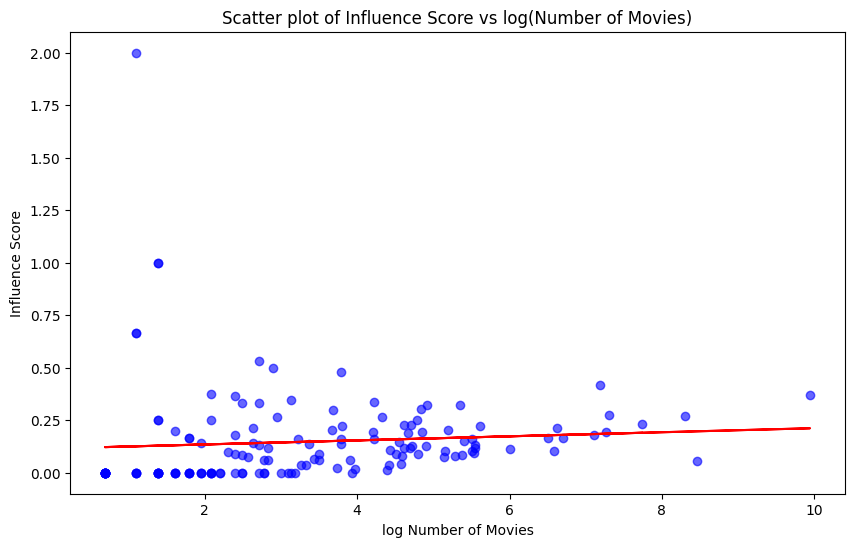

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df_us_influence['log_number_of_movies'], 
    df_us_influence['Influence_score'], 
    color='blue', 
    alpha=0.6
)
#add the linear regression line
z = np.polyfit(df_us_influence['log_number_of_movies'], df_us_influence['Influence_score'], 1)
p = np.poly1d(z)
plt.plot(df_us_influence['log_number_of_movies'],p(df_us_influence['log_number_of_movies']),"r-")
plt.title('Scatter plot of Influence Score vs log(Number of Movies)')
plt.xlabel('log Number of Movies')
plt.ylabel('Influence Score')

plt.show()

Too Many small countries with few films, resulting in a high standard deviation (more than 6 times the average term count) and not relevant linear regression, clustering was necessary. The first clustering that seemed the most logical to us was geographical clustering.


C:\Users\Oscar\AppData\Local\Temp\ipykernel_20496\1150267948.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
C:\Users\Oscar\AppData\Local\Temp\ipykernel_20496\1150267948.py:6: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))


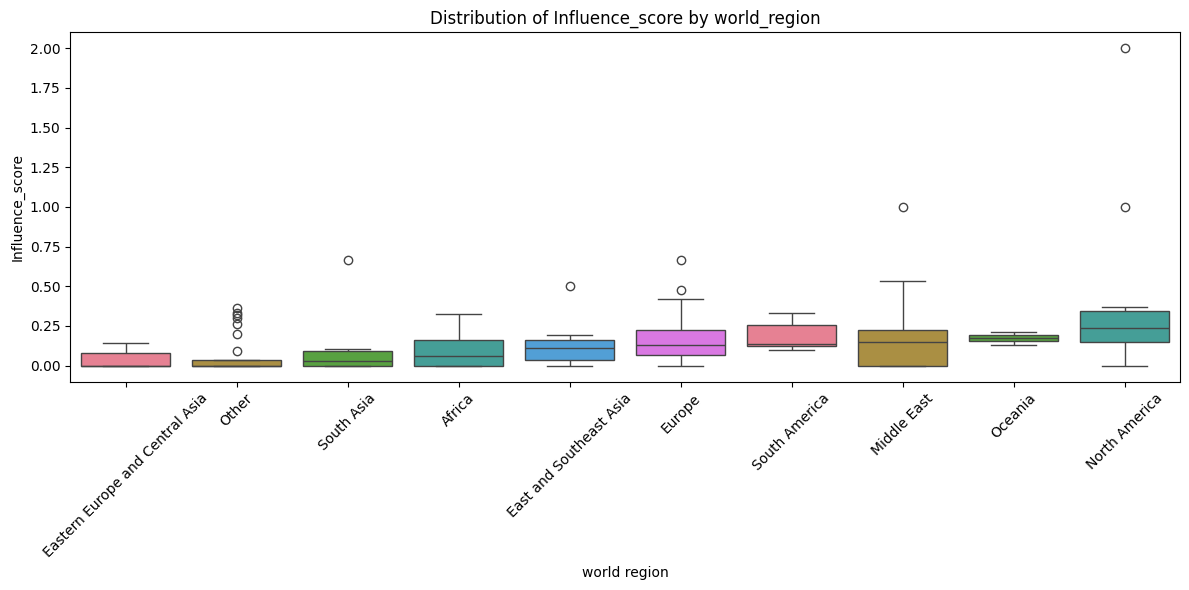

In [ ]:
plt.figure(figsize=(12, 6))
# Sort by median ratio
median_order = df_us_influence.groupby('World_region')['Influence_score'].median().sort_values().index

# Create the boxplot with the sorted order
sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
plt.title('Distribution of Influence_score by world_region')
plt.xlabel('world region')
plt.ylabel('Influence_score')


plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [ ]:
df_us_influence.groupby('World_region')['Influence_score'].describe() #Checking the uniformity of the clusters regarding our feature

,count,mean,std,min,25%,50%,75%,max
World_region,,,,,,,,
Africa,17.0,0.087246,0.094800,0.000000,0.000000,0.060606,0.159091,0.323529
East and Southeast Asia,13.0,0.128948,0.128923,0.000000,0.036145,0.113580,0.162602,0.500000
Eastern Europe and Central Asia,9.0,0.038162,0.059185,0.000000,0.000000,0.000000,0.082949,0.142857
Europe,42.0,0.161546,0.148088,0.000000,0.065202,0.127815,0.224474,0.666667
Middle East,11.0,0.209803,0.309140,0.000000,0.000000,0.147368,0.222656,1.000000
North America,10.0,0.448792,0.611118,0.000000,0.148810,0.236722,0.344772,2.000000
Oceania,2.0,0.173358,0.057340,0.132812,0.153085,0.173358,0.193631,0.213904
Other,29.0,0.065831,0.123967,0.000000,0.000000,0.000000,0.035714,0.363636
South America,8.0,0.182935,0.086291,0.101215,0.124561,0.135632,0.253289,0.333333


The geographical clusters are not very uniform (2 countries for Oceania vs 42 for Europe), and not homogeneous regarding the ratio feature. Indeed, we observe a high standard deviation in each country. This cluster is very interesting in term of interpretability but we should consider another clustering method to solve these issues.

Areas for improvement for this study:

 - The identification of US-related terms could be enhanced, either manually or through more advanced techniques. We have begun exploring Natural Language Processing (NLP) methods that could assist with this task and even enable us to assess the influence of each country on others based on the themes present in the film summaries. We started to look at Transformer from HuggingFace and Spacy that could be used for this task

 - The current geographical clustering may not be optimal due to its lack of uniformity and the high variance in the ratios. To address this, we plan to experiment with clustering algorithms like KNN or centroids (as we can define an euclidian distance with the ratio) to achieve more homogeneous,uniform and interpretable clusters.




### Clusterisation : k-means choosen with silhouette score

In [ ]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

We try to determine the best K for the K-means clusterisation, let's see

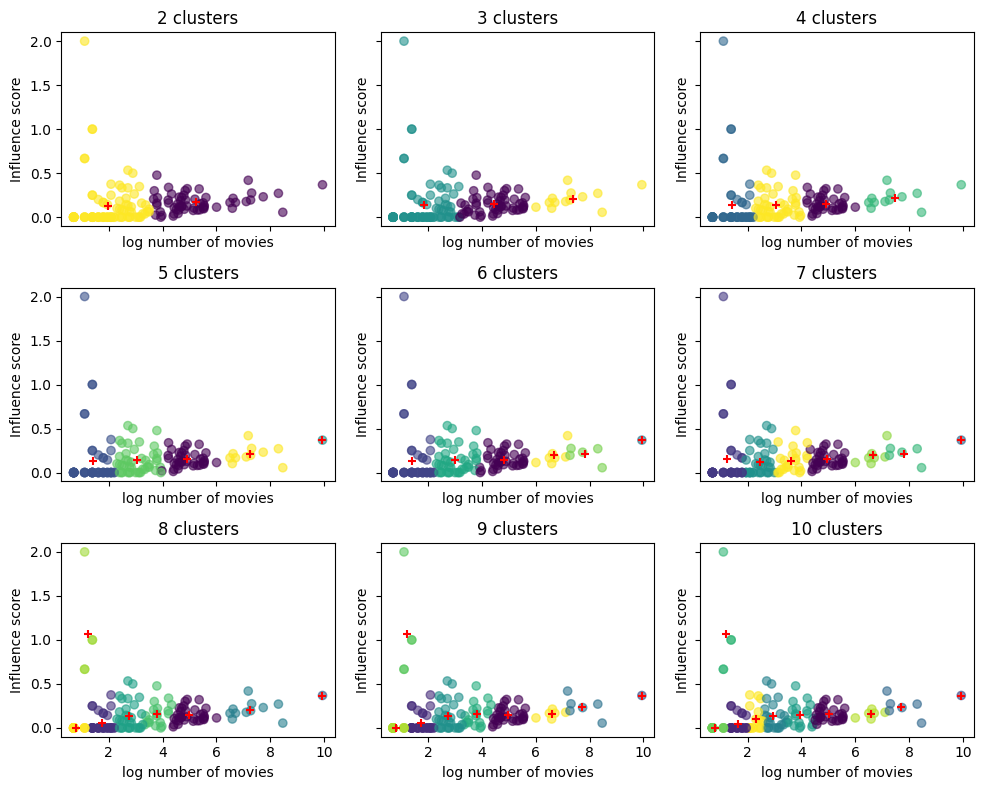

In [ ]:
X = df_us_influence[['log_number_of_movies', 'Influence_score']].values

MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

# Compute number of row and columns
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    # Plot the data by using the labels as color
    ax.scatter(X[:,0], X[:,1], c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_xlabel("log number of movies")
    ax.set_ylabel("Influence score")
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

Let's test the silhouette score

Text(0, 0.5, 'Silhouette score')

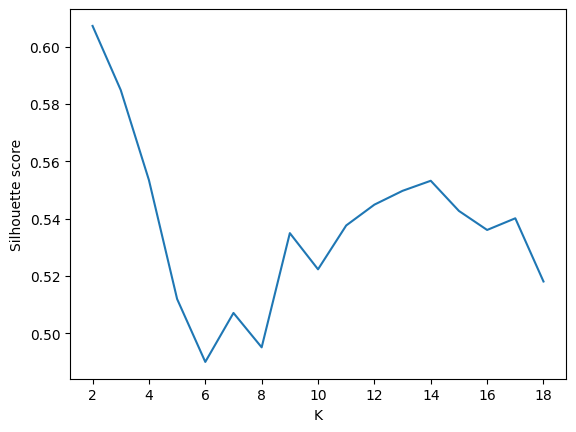

In [ ]:
silhouettes = []

# Try multiple k
for k in range(2, 19):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X)
    # Get the Silhouette score
    score = silhouette_score(X, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

In [ ]:
silhouettes.head(15).sort_values(by='score', ascending=False)


,k,score
0,2,0.607210
1,3,0.584839
2,4,0.553450
12,14,0.553228
11,13,0.549723
10,12,0.544900
13,15,0.542708
9,11,0.537647
14,16,0.536075
7,9,0.534970


Let's conserve the 3 clusters given by the best score of K-means 

In [ ]:
kmeans_final = KMeans(n_clusters=3, random_state=42).fit(X)
df_us_influence['cluster'] = kmeans_final.labels_
df_us_influence[df_us_influence['cluster']==2].head(13)

,Country,US_Term_Count,Number of movies,Influence_score,log_number_of_movies,World_region,cluster
0,France,531,2297,0.231171,7.739359,Europe,2
3,United States of America,7657,20789,0.368320,9.942179,North America,2
4,India,262,4752,0.055135,8.466321,South Asia,2
5,Australia,160,748,0.213904,6.617403,Oceania,2
7,Canada,409,1492,0.274129,7.307873,North America,2
8,Germany,551,1315,0.419011,7.181592,Europe,2
10,United Kingdom,1093,4037,0.270746,8.303257,Europe,2
12,Spain,111,667,0.166417,6.502790,Europe,2
13,Italy,217,1222,0.177578,7.108244,Europe,2
15,China,46,405,0.113580,6.003887,East and Southeast Asia,2


C:\Users\Oscar\AppData\Local\Temp\ipykernel_20496\3552391364.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
C:\Users\Oscar\AppData\Local\Temp\ipykernel_20496\3552391364.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(x='cluster', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))


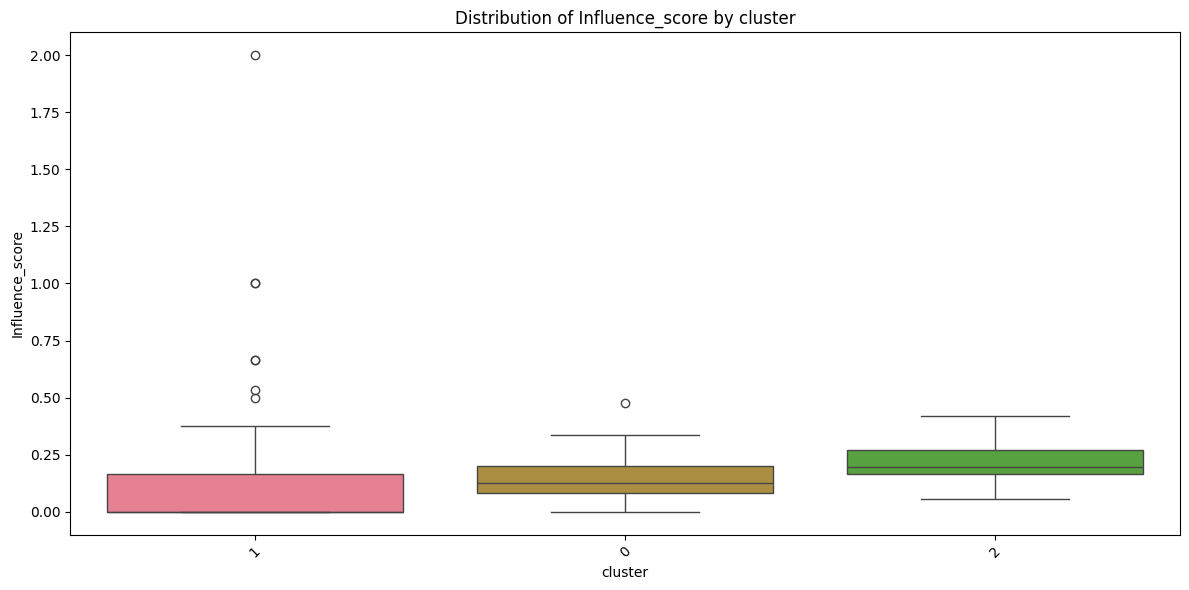

In [ ]:
plt.figure(figsize=(12, 6))
# Sort by median ratio
median_order = df_us_influence.groupby('cluster')['Influence_score'].median().sort_values().index

# Create the boxplot with the sorted order
sns.boxplot(x='cluster', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
plt.title('Distribution of Influence_score by cluster')
plt.xlabel('cluster')
plt.ylabel('Influence_score')


plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [ ]:
df_us_influence.groupby('cluster')['Influence_score'].describe() #Checking the uniformity of the clusters regarding our feature

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,54.0,0.144550,0.098856,0.000000,0.080808,0.125933,0.202143,0.477273
1,80.0,0.138395,0.298718,0.000000,0.000000,0.000000,0.166667,2.000000
2,13.0,0.211892,0.102864,0.055135,0.166417,0.195682,0.270746,0.419011


### NLP methods utilization

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

#Summary example
resume = "The character travels through the streets of Paris, facing challenges that test his courage. He then fly straight to Spain"

# We apply the NLP model to the summary
doc = nlp(resume)

# Extract the geographical entities from the summary
pays_detectes = [ent.text for ent in doc.ents if ent.label_ == "GPE"]  # GPE = Geopolitical Entity

print(pays_detectes)

['Paris', 'Spain']


We will expand our analysis by exploring the influence of specific cities or countries on movie themes. One approach would be to create an additional influence feature based on the frequency of mentions of cities or countries in the movie summaries. This would allow us to quantify the impact of these locations on the themes, potentially revealing patterns of cultural influence or regional trends within the film industry.

In [ ]:
from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
resume = "Five men attend the same gym in Berlin. None of them seem to have anything in common, but all five have not enough confidence to meet or develop relationships with the opposite sex, and what it really means to be a man or what women expect of them. Günther Stobanski, portrayed by Christian Ulmen, fails with Internet dating, music producer Jerome Ades, portrayed by Til Schweiger, passes from a sentimental break-up story to another. Roland Feldberg, a train driver portrayed by Wotan Wilke Möhring, snubs his wife Susanne Feldberg portrayed by Nadja Uhl. The girlfriend of Philip Henrion, portrayed by Maxim Mehmet, becomes pregnant at a young age. Niklas Michalke, a solicitor portrayed by Florian David Fitz, is terrified by his impending marriage, while Bruce Berger, a singer portrayed by Justus von Dohnányi, tries to pursue his singing career."

# Here we define the label (countries in our case)
labels = ["United States", "France", "India", "Germany"]

result = nlp(resume, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head()

c:\Users\Oscar\anaconda3\envs\projet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Label,Score
0,Germany,0.887495
1,India,0.043266
2,France,0.041677
3,United States,0.027562


The function classifies the movie summary by calculating the likelihood that represent the probability that the events in the movie take place in a specific country, using a pre-trained zero-shot model. This means the model doesn't need to be retrained on the specific countries, as it has already learned general language patterns and can apply them to this kinf of task.

This second approach can be very useful for enriching our analysis about cultural influence, especially by applying a threshold to filter the results, which adds depth to the explanations. We will also evaluate the model's performance by testing precision, recall, and accuracy across several labeled summaries. Additionally, experimenting with different thresholds when displaying the results could provide further insights. The F-score could also be a valuable metric to assess the balance between precision and recall.

### IV.4 Character Study for Cultural Influence Analysis

In [ ]:
from scriptculture import process_data_character          # Import the function that processes the data for this study

df_character_influence = process_data_character()
df_character_influence.head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
0,'Baby' Louise,/m/0c0lv89,Diane Pace,Gypsy,1962-01-01,[United States of America],[United States of America],1
1,ACP Jai Dixit,/m/0220_c2,Abhishek Bachchan,Dhoom,2004-08-27,[India],[India],1
2,Abigail Chase,/m/0k14v6,Diane Kruger,National Treasure,2004-11-08,[United States of America],[United States of America],1
3,Abraham Lincoln,/m/0k89pf,Henry Fonda,Young Mr. Lincoln,1939-01-01,[United States of America],[United States of America],1
4,Abraham Van Helsing,/m/0jxjsg,Edward Van Sloan,Dracula,1931-02-12,[United States of America],"[United Kingdom, France, United States of Amer...",4


For this analysis, we grouped the characters that appeared in different countries (from the character_cluster database). 

The processed dataset that we'll use for this analyse is completed with the features :
 - first_movie_name : The first movie in which the character appeared
 - first_apperance_date : The date of release of the first movie 
 - origin_country : The country of the first movie
 - all_countries : the countries of origin of all the movies in which the character has appeared 
 - number_countries : count of all_countries


In [ ]:
df_character_influence.describe()

,number_countries
count,970.000000
mean,1.797938
std,1.161116
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


970 characters appear in multiple films; on average, they appear in 1.8 different countries. They feature in up to 8 different films. Let's look at the distribution of the number of countries

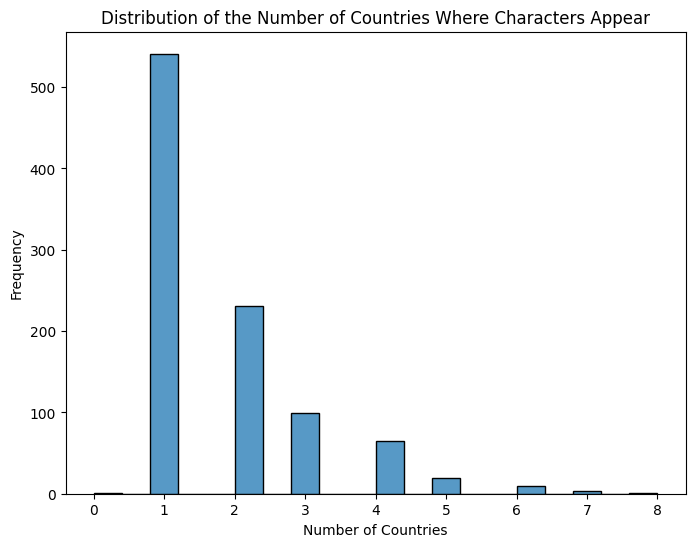

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_character_influence['number_countries'], kde=False, bins=20)

plt.title('Distribution of the Number of Countries Where Characters Appear')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(df_character_influence[df_character_influence['number_countries'] > 1].count()) #Number of characters that appear in more than one country
print("number of influence point to be given :",df_character_influence['number_countries'].sum()-970) #Number of influence point to be given

Character                      428
character_actor_freebase_id    428
actor_name                     428
first_movie_name               428
first_apperance_date           428
origin_country                 428
all_countries                  428
number_countries               428
dtype: int64
number of influence point to be given : 774


Of the 970 characters, 428 appear in movies produced across different countries, which is not a large sample. We will keep this in mind as we test the significance of our study.

For each character appearing in a movie produced by a different country, we will assign 1 influence point to the character's origin country. This results in a total of 774 points being assigned.

A major concern that remains is whether the method of taking the first movie appearance as the origin country of a character is reliable.

Let's test this with the character that appears in movies produced in the most countries.

In [ ]:
#find the character that appear in 8 countries and show all the origin countries one by one

df_character_influence[df_character_influence['number_countries'] == 8].head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Panama, Germany, United Kingdom, Austria, Uni...",8


The character appearing in productions from the most different countries is Cardinal Richelieu (French origin). However, with our initial method, the influence points would not have been distributed to France but to UK, US and Spain.

This analysis drives us to explore other methods for identifying character origins. One possibility is to leverage Natural Language Processing (NLP) models, such as spaCy to analyze movie summaries geographical terms and better determine the character's origin. 

Additionally, using embedding models like Hugging Face transformers could help identify implicit relationships within the movie summaries and find where the history of the movie take place and deduct the characters origin from this.